In [1]:
!pip install optuna matplotlib torchvision --quiet

ERROR: mlflow 1.15.0 has requirement alembic<=1.4.1, but you'll have alembic 1.8.1 which is incompatible.


In [2]:
import torch
import optuna
import numpy as np
import matplotlib.pylab as plt
from IPython.display import clear_output
import torch.nn as nn 
import torch.optim as optim

import antidistil
import pipeline
import consts
from importlib import reload
import plot
import json
reload(plot)
reload(antidistil)
reload(pipeline)
reload(consts)
plot.prepare_for_plots()

Using cuda device
Using cuda device


<Figure size 864x720 with 0 Axes>

In [3]:
train_dataloader, test_dataloader = pipeline.get_data()

In [4]:
def train_antidistill_loop(l1, l2, l3, l4):

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for i in range(consts.num_repeats):
        clear_output()
        print(f"Model {i+1}\n-------------------------------"
                          "\n-------------------------------")

        torch.manual_seed(i)

        teacher = pipeline.make_teacher_model()
        teacher.load_state_dict(torch.load(pipeline.get_path()+f'/teacher_5cl_{i}.pt'))
        model = antidistil.make_student_model()

        mask = torch.tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=torch.float).to(consts.device)
        
        loss_fn = antidistil.altidistill_loss
        optimizer = optim.Adam(model.parameters(), lr=consts.student_5_antidistil_learning_rate)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)

        lambdas = [l1, l2, l3, l4]
        
        for epoch in range(10):
            print(f"Epoch {epoch+1}\n-------------------------------")

            pipeline.antidistil_loop(teacher, model, lambdas, mask, train_dataloader, 
                                    loss_fn, optimizer, scheduler, noise_dist='uniform', noise_eps=1e-1)

        optimizer = optim.Adam(model.parameters(), lr=consts.student_5_learning_rate)    

        mask = torch.ones(10).to(consts.device)

        loss_fn = nn.CrossEntropyLoss()

        for epoch in range(10):
            print(f"Epoch {epoch+1}\n-------------------------------")

            pipeline.train_loop(model, history, mask, train_dataloader, loss_fn, optimizer)
            pipeline.test_loop(model, history, mask, test_dataloader, loss_fn)

        pipeline.test_loop_fsgm(model, history, mask, test_dataloader, loss_fn, consts.fsgm_eps)
        pipeline.test_loop_noise(model, history, mask, test_dataloader, consts.noise_eps)

    return np.array(history['fsgm_noise_acc']).mean(axis=0)[-1]

In [5]:
def objective(trial):
    l1 = trial.suggest_float('l1', 0, 1)
    l2 = trial.suggest_float('l2', 0, 1)
    l3 = trial.suggest_float('l3', 0, 1)
    l4 = trial.suggest_float('l4', 0, 1)
    
    acc = train_antidistill_loop(l1, l2, l3, l4)

    return acc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

Batch #:   0%|          | 0/235 [00:00<?, ?it/s]

Model 10
-------------------------------
-------------------------------
Epoch 1
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Train Loss: 43.73215128716002
Train Acc: 0.8793666666666666
Epoch 2
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Train Loss: 5.521642500288943
Train Acc: 0.9437
Epoch 3
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Train Loss: 0.31441834600681956
Train Acc: 0.948
Epoch 4
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Train Loss: 0.20516151738293628
Train Acc: 0.9489
Epoch 5
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Train Loss: 0.19103498487396442
Train Acc: 0.949
Epoch 6
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Train Loss: 0.1807746598061095
Train Acc: 0.95
Epoch 7
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Train Loss: 0.1747091699153819
Train Acc: 0.9500333333333333
Epoch 8
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Train Loss: 0.17080631218057998
Train Acc: 0.9501666666666667
Epoch 9
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Train Loss: 0.16582100863786453
Train Acc: 0.9506666666666667
Epoch 10
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Train Loss: 0.16162113456967028
Train Acc: 0.9516666666666667
Epoch 1
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 83.3%, Validation loss: 0.480742 

Epoch 2
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 85.7%, Validation loss: 0.400904 

Epoch 3
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 86.6%, Validation loss: 0.379023 

Epoch 4
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 86.9%, Validation loss: 0.368292 

Epoch 5
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 87.3%, Validation loss: 0.362135 

Epoch 6
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 87.5%, Validation loss: 0.359691 

Epoch 7
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 87.7%, Validation loss: 0.354056 

Epoch 8
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 87.8%, Validation loss: 0.352673 

Epoch 9
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 87.9%, Validation loss: 0.353671 

Epoch 10
-------------------------------


Batch #:   0%|          | 0/40 [00:00<?, ?it/s]           

Validation accuracy: 88.0%, Validation loss: 0.353588 



Batch #:   0%|          | 0/40 [00:00<?, ?it/s]         

FSGM Accuracy [0.8805, 0.8522, 0.8238, 0.789, 0.7535, 0.7161, 0.6761, 0.6404, 0.6049, 0.5672]


[I 2022-11-03 20:54:56,448] Trial 9 finished with value: 0.5643499999999999 and parameters: {'l1': 0.350961620679606, 'l2': 0.9160254440218502, 'l3': 0.6240259442308044, 'l4': 0.6591129819117321}. Best is trial 1 with value: 0.57722.


Noise Accuracy [0.8805, 0.8782, 0.8734, 0.8615, 0.8449, 0.8284, 0.8075, 0.7741, 0.7479, 0.7092]


In [6]:
study.best_trials

[FrozenTrial(number=1, values=[0.57722], datetime_start=datetime.datetime(2022, 11, 3, 15, 8, 34, 823046), datetime_complete=datetime.datetime(2022, 11, 3, 15, 47, 2, 163639), params={'l1': 0.716363757180193, 'l2': 0.6256876037711583, 'l3': 0.0027526129759972706, 'l4': 0.5634907950570721}, distributions={'l1': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'l2': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'l3': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'l4': FloatDistribution(high=1.0, log=False, low=0.0, step=None)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=1, state=TrialState.COMPLETE, value=None)]

In [7]:
best_params = optuna.importance.get_param_importances(study)
best_params

OrderedDict([('l4', 0.3623355591075348),
             ('l3', 0.24462296467939607),
             ('l1', 0.2169215078949108),
             ('l2', 0.1761199683181584)])

In [8]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for i in range(consts.num_repeats):
    clear_output()
    print(f"Model {i+1}\n-------------------------------"
                      "\n-------------------------------")

    torch.manual_seed(i)

    teacher = pipeline.make_teacher_model()
    teacher.load_state_dict(torch.load(pipeline.get_path()+f'/teacher_5cl_{i}.pt'))
    model = antidistil.make_student_model()

    mask = torch.tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0], dtype=torch.float).to(consts.device)
    
    loss_fn = antidistil.altidistill_loss
    optimizer = optim.Adam(model.parameters(), lr=consts.student_5_antidistil_learning_rate)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)

    lambdas = [value for _, value in best_params.items()]
    
    for epoch in range(consts.student_5_antidistil_epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")

        pipeline.antidistil_loop(teacher, model, lambdas, mask, train_dataloader, 
                                loss_fn, optimizer, scheduler, noise_dist='uniform', noise_eps=1e-1)

    optimizer = optim.Adam(model.parameters(), lr=consts.student_5_learning_rate)    

    mask = torch.ones(10).to(consts.device)

    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(consts.student_5_training_epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")

        pipeline.train_loop(model, history, mask, train_dataloader, loss_fn, optimizer)
        pipeline.test_loop(model, history, mask, test_dataloader, loss_fn)

    pipeline.test_loop_fsgm(model, history, mask, test_dataloader, loss_fn, consts.fsgm_eps)
    pipeline.test_loop_noise(model, history, mask, test_dataloader, consts.noise_eps)

Batch #:   0%|          | 0/235 [00:00<?, ?it/s]

Model 10
-------------------------------
-------------------------------
Epoch 1
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Train Loss: 11.95999081388433
Train Acc: 0.8777666666666667
Epoch 2
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Train Loss: 1.5876479910409196
Train Acc: 0.9418
Epoch 3
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Train Loss: 0.14782552110387923
Train Acc: 0.9471666666666667
Epoch 4
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Train Loss: 0.1082189438190866
Train Acc: 0.9486
Epoch 5
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Train Loss: 0.1023659256385996
Train Acc: 0.949
Epoch 6
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Train Loss: 0.09756870945083335
Train Acc: 0.9494666666666667
Epoch 7
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Train Loss: 0.09373164406799256
Train Acc: 0.9501666666666667
Epoch 8
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Train Loss: 0.09197595132158158
Train Acc: 0.9507333333333333
Epoch 9
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Train Loss: 0.08948300893002369
Train Acc: 0.951
Epoch 10
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Train Loss: 0.08741343682433697
Train Acc: 0.9513333333333334
Epoch 11
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Train Loss: 0.0852056788161714
Train Acc: 0.9523
Epoch 12
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Train Loss: 0.08334054195500434
Train Acc: 0.9531666666666667
Epoch 13
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Train Loss: 0.08174110278487205
Train Acc: 0.9540333333333333
Epoch 14
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Train Loss: 0.08072237542017978
Train Acc: 0.9541
Epoch 15
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Train Loss: 0.07913345016063528
Train Acc: 0.9547333333333333
Epoch 1
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 83.7%, Validation loss: 0.489895 

Epoch 2
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 85.6%, Validation loss: 0.413670 

Epoch 3
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 86.6%, Validation loss: 0.382507 

Epoch 4
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 87.2%, Validation loss: 0.366218 

Epoch 5
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 87.3%, Validation loss: 0.359852 

Epoch 6
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 87.6%, Validation loss: 0.354174 

Epoch 7
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 87.6%, Validation loss: 0.353093 

Epoch 8
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 87.8%, Validation loss: 0.352034 

Epoch 9
-------------------------------


Batch #:   0%|          | 0/235 [00:00<?, ?it/s]          

Validation accuracy: 88.0%, Validation loss: 0.350400 

Epoch 10
-------------------------------


Batch #:   0%|          | 0/40 [00:00<?, ?it/s]           

Validation accuracy: 88.0%, Validation loss: 0.352875 



Batch #:   0%|          | 0/40 [00:00<?, ?it/s]         

FSGM Accuracy [0.88, 0.8522, 0.8221, 0.7914, 0.7554, 0.7188, 0.6812, 0.6435, 0.6105, 0.5717]


Noise Accuracy [0.88, 0.8796, 0.8713, 0.8642, 0.8477, 0.8287, 0.8084, 0.7678, 0.7342, 0.6943]


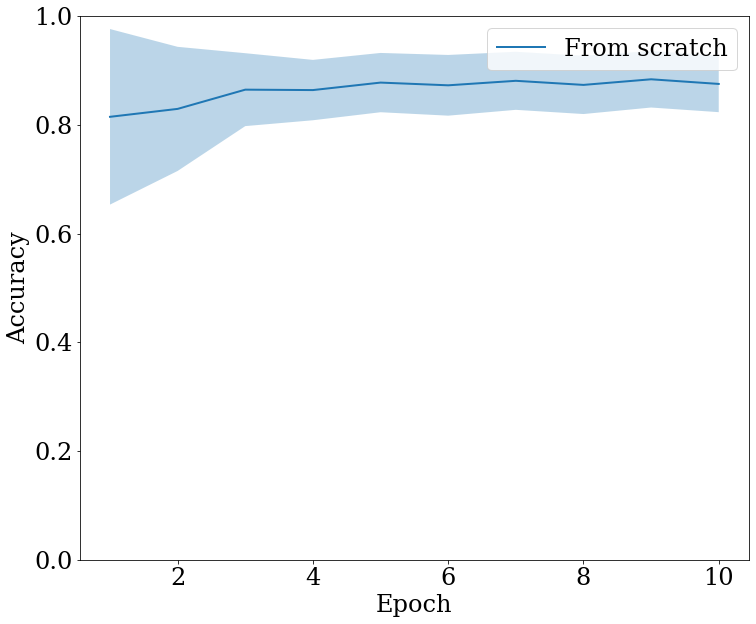

In [9]:
reload(plot)
plot.prepare_for_plots()
plot.plot_variance([history], np.arange(1, consts.student_5_training_epochs + 1),
                   ['From scratch'], 'val_acc', 
                    'Epoch', 'Accuracy')

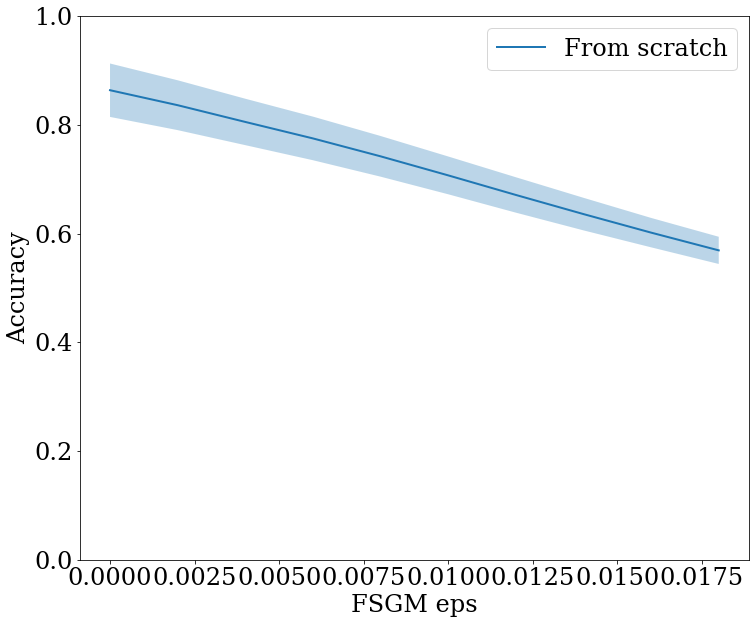

In [10]:
reload(plot)
plot.prepare_for_plots()
plot.plot_variance([history], consts.fsgm_eps,
                   ['From scratch'], 'fsgm_noise_acc', 
                    'FSGM eps', 'Accuracy')

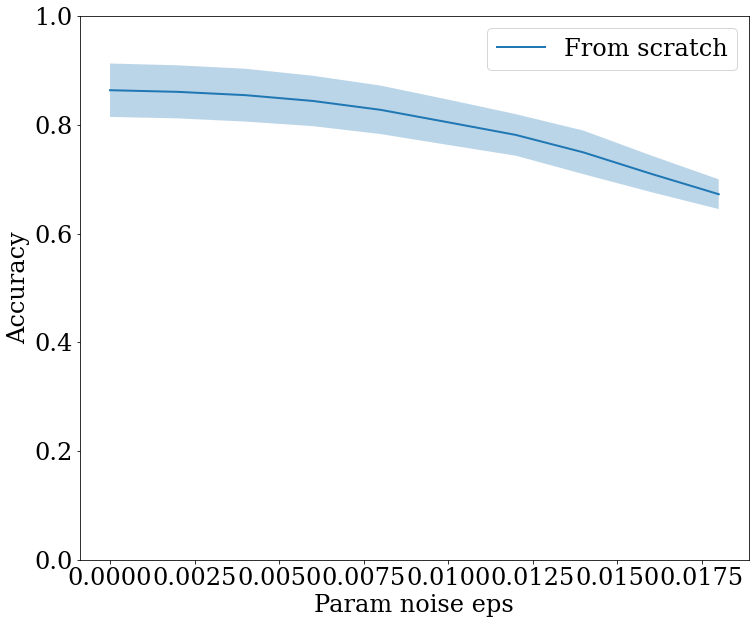

In [11]:
reload(plot)
plot.prepare_for_plots()
plot.plot_variance([history], consts.fsgm_eps,
                   ['From scratch'], 'param_noise_acc', 
                    'Param noise eps', 'Accuracy')

In [16]:
with open(pipeline.get_path()+'/history_best_antidistill_with_L4.json', 'w') as out:
    out.write(json.dumps(history))